In [1]:
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point
import pandas as pd
import geopandas as gpd
import networkx as nx
from scipy.spatial.distance import cdist
import os

In [2]:
# Basic geographic setup

In [3]:
from citychef import spatial
from citychef import graph
from citychef import household as hh
from citychef import tree
from citychef import osm
from citychef import gtfs

In [4]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [5]:
city_dir = "./sample_setup"

if not os.path.exists(city_dir):
    os.mkdir(city_dir)
else:
    print("WARNING - potentially overwritting previous results")

WARNING - potentially overwritting previous results


In [24]:
bbox = np.array([[0,0],[.01,.01]])  # min x, min y, max x, max y (DEGREES)
centres = spatial.Centres(bbox, number=1)
facilities = {
    'households': spatial.Clusters(centres, size=1000, sigma=.005),
}
bbox = spatial.collect_bbox(facilities) # adjust the bbox for max extends

(-0.011300460885929942,
 0.01817374360215535,
 -0.015412800767529093,
 0.017457075842093956)

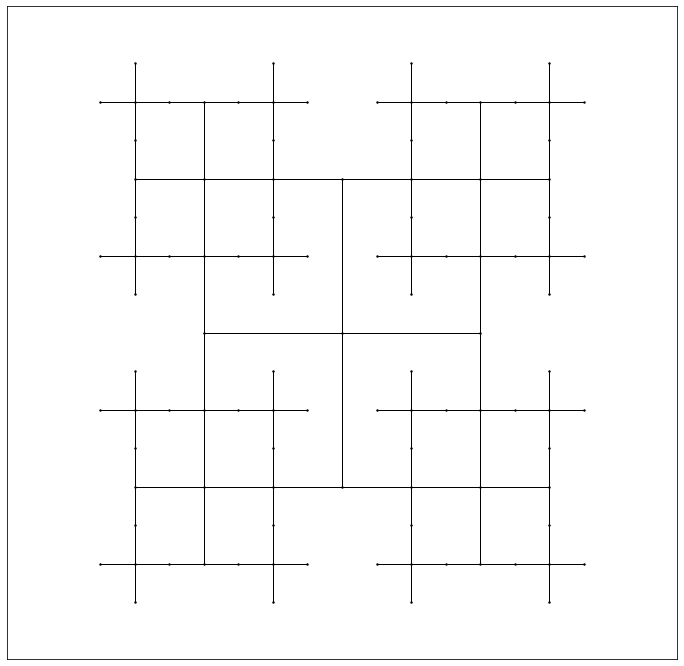

In [25]:
car_network = graph.TreeNetwork(
    bbox, facilities['households'], grid='regular', max_points=200
)
car_network.plot()
plt.axis('equal')

In [31]:
buses = graph.Transit(car_network, facilities['households'], density_radius=.0001)
buses.build_routes(num_routes=1, max_length=11, min_length=11, straightness=2)

(-0.011300460885929942,
 0.01817374360215535,
 -0.015412800767529093,
 0.017457075842093956)

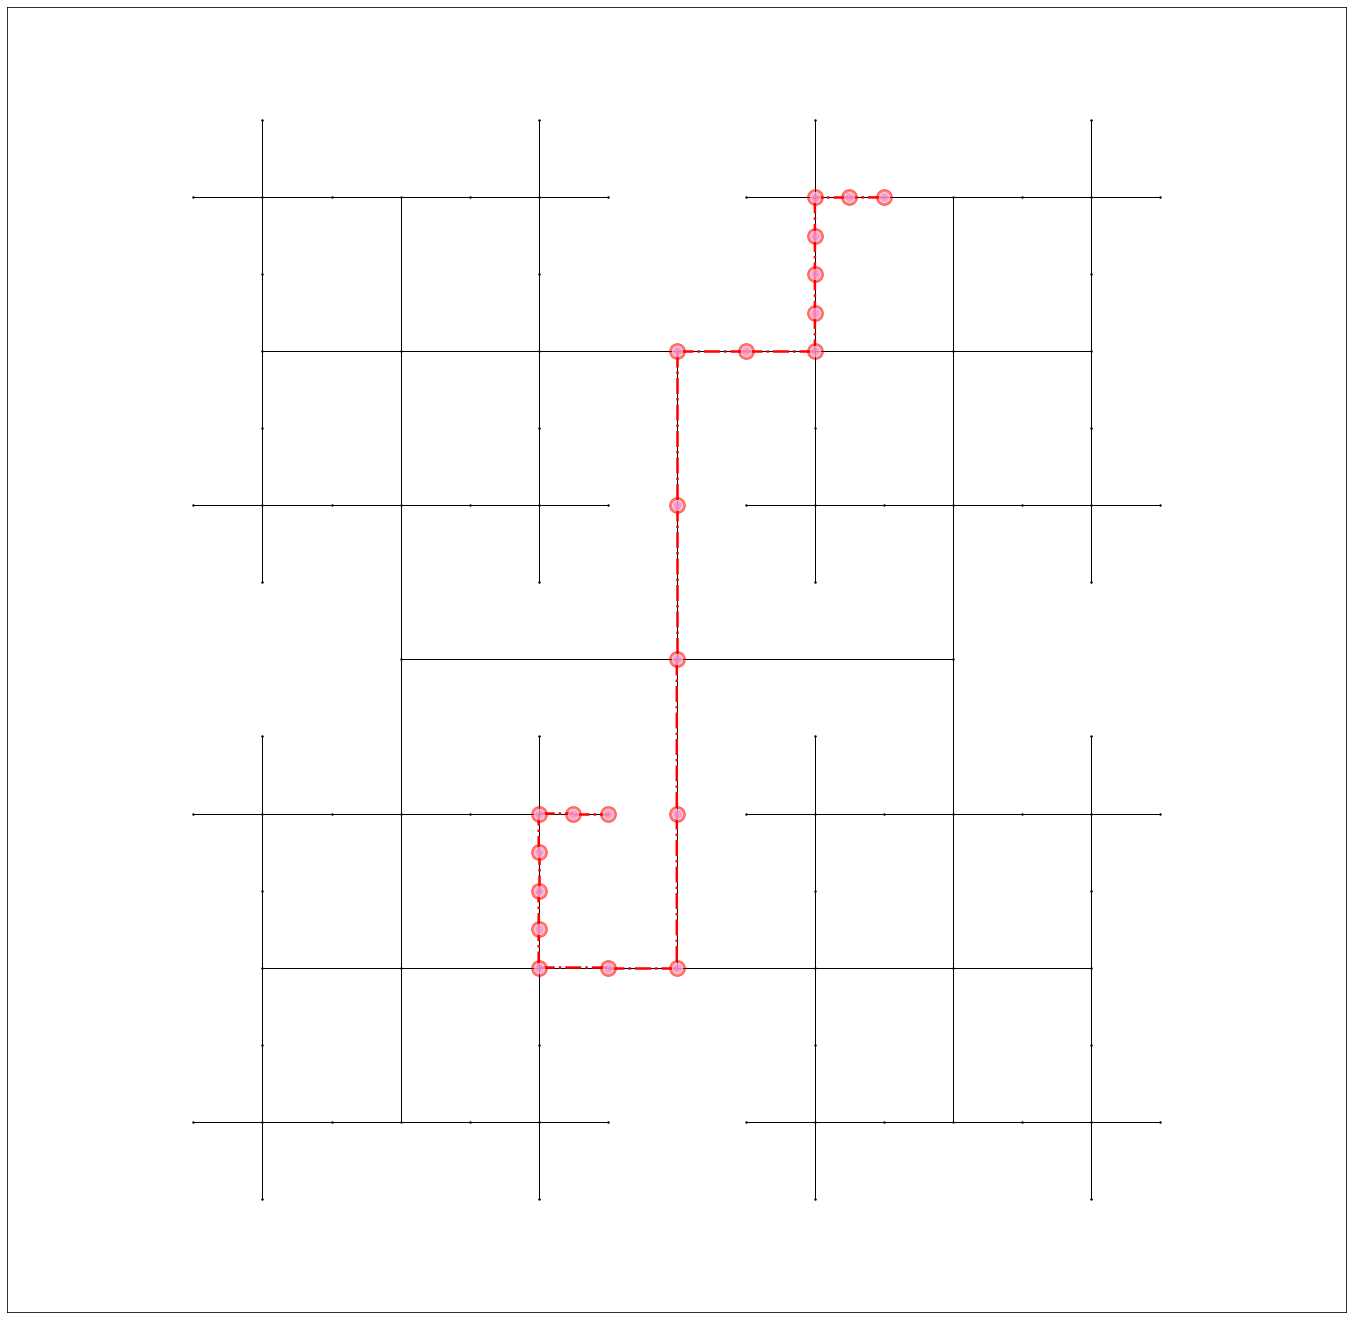

In [32]:
buses.interpolate_routes()
buses.jitter_locations(1e-08)
fig, ax = plt.subplots(1, 1, figsize=(24, 24))
car_network.plot(ax=ax)
buses.plot(ax=ax)
plt.axis('equal')

In [10]:
# check min and max distances
print(buses.min_link_length * 111139)
print(buses.max_link_length * 111139) # approx conv to m

49.73676086303103
304.2120987094043


In [33]:
osm.nx_to_osm(
    g=car_network.g,
    path=os.path.join(city_dir, "osm.xml")
)

Output()

In [34]:
gtfs.build_gtfs(
    name="",
    transit=buses,
    out_dir=city_dir,
    agency_id=0,
    agency_name='test_bus_inc',
)

Output()

In [35]:
# first we extract potential locations for stations, we force stations to match vertices
# from the road ntwork, eg :
potential_stations = np.array([v['pos'] for k, v in car_network.g.nodes.items() if k[:2] == '00'])
rail_network = graph.DelaunayNetwork(potential_stations)

trains = graph.Transit(rail_network, facilities['households'])
train_routes = trains.build_routes(num_routes=2, max_length=10, min_length=10, straightness=30)

fig, ax = plt.subplots(1, 1, figsize=(24, 24))
car_network.plot(ax=ax)
trains.plot(ax=ax, line_colour='blue')

/home/rico/Documents/citychef/citychef/spatial.py:309: RuntimeWarning: invalid value encountered in true_divide
  return (array - min(array)) / (max(array) - min(array))


ValueError: probabilities contain NaN

In [ ]:
total_train_graph = trains.graph
fig, ax = plt.subplots(1, 1, figsize=(24, 24))
car_network.plot(ax=ax)
buses.plot(ax=ax)
trains.plot(ax=ax, line_colour='blue')

ValueError: cannot apply compose_all to an empty list

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(24, 24))
spatial.plot_facilities(facilities, centres=centres, ax=ax)
car_network.plot(ax=ax)
buses.plot(ax=ax)
trains.plot(ax=ax, line_colour='blue')
fig.patch.set_visible(False)
# ax.axis('off')
# plt.axis('equal')